In [1]:
import re
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as ss
import matplotlib.pyplot as plt
from matplotlib import style, colors
from matplotlib import gridspec

matplotlib.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8, 6)



use all calls from strelka: this is prefered since this takes into consideration of all soamtic calls:snvs and indels, high/moderate/low/modifier impacts.

In [2]:
# f1 = '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/124_patients/HIGH_MODERATE_SNV_summary_with_normal_with_AF.tsv'
# f1 = '/projects/trans_scratch/validations/EXPANDS/124_patients/HIGH_MODERATE_SNV_summary_with_normal_with_AF.tsv'
f1 = '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/124_patients_new/HIGH_MODERATE_SNV_summary_with_normal_with_AF_filtered_somatic.tsv'
df = pd.read_csv(f1, sep='\t', comment='#', usecols=['gene', 'chromosome', 'position', 'ref_base', 'alt_base', 'patient_ID', 'adj_t_DNA_AF', 'in_strelka'])
# df = pd.read_csv(f1, sep='\t', comment='#', usecols=['gene', 'patient_ID', 't_DNA_AF', 'in_strelka'])
df.head(2)

/home/szong/anaconda3/envs/szvenv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,gene,chromosome,position,ref_base,alt_base,patient_ID,in_strelka,adj_t_DNA_AF
0,SAMD11,1,865615,C,A,HTMCP-03-06-02007_malignant,not_in_strelka,0.81
1,SAMD11,1,878183,C,T,HTMCP-03-06-02214_malignant,in_strelka,0.32


In [3]:
df['snv_id'] = df[['gene', 'chromosome', 'position', 'ref_base', 'alt_base']].astype(str).apply(lambda x: '_'.join(x), axis=1)

In [4]:
df.head(2)

,gene,chromosome,position,ref_base,alt_base,patient_ID,in_strelka,adj_t_DNA_AF,snv_id
0,SAMD11,1,865615,C,A,HTMCP-03-06-02007_malignant,not_in_strelka,0.81,SAMD11_1_865615_C_A
1,SAMD11,1,878183,C,T,HTMCP-03-06-02214_malignant,in_strelka,0.32,SAMD11_1_878183_C_T


In [5]:
# this should have adj_t_DNA_AF value
df[(df.patient_ID == 'HTMCP-03-06-02341_malignant') & (df.in_strelka == 'in_strelka')].head(2)

,gene,chromosome,position,ref_base,alt_base,patient_ID,in_strelka,adj_t_DNA_AF,snv_id
145,PLEKHG5,1,6556607,C,G,HTMCP-03-06-02341_malignant,in_strelka,0.16,PLEKHG5_1_6556607_C_G
740,SERINC2,1,31896559,C,G,HTMCP-03-06-02341_malignant,in_strelka,0.18,SERINC2_1_31896559_C_G


In [6]:
# filter for strelka calls
df = df[df.in_strelka == 'in_strelka']
df.head(2)

,gene,chromosome,position,ref_base,alt_base,patient_ID,in_strelka,adj_t_DNA_AF,snv_id
1,SAMD11,1,878183,C,T,HTMCP-03-06-02214_malignant,in_strelka,0.32,SAMD11_1_878183_C_T
2,KLHL17,1,899543,G,C,HTMCP-03-06-02120_malignant,in_strelka,0.30,KLHL17_1_899543_G_C


In [7]:
df.shape

(40700, 9)

In [8]:
df['patient'] = df['patient_ID'].str.replace('_malignant', '')
df = df.drop('patient_ID', axis=1)

In [9]:
df.head(2)

,gene,chromosome,position,ref_base,alt_base,in_strelka,adj_t_DNA_AF,snv_id,patient
1,SAMD11,1,878183,C,T,in_strelka,0.32,SAMD11_1_878183_C_T,HTMCP-03-06-02214
2,KLHL17,1,899543,G,C,in_strelka,0.30,KLHL17_1_899543_G_C,HTMCP-03-06-02120


In [10]:
# add in hiv status and histology
# get meta track for example histology
f3 ='/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/124_patients/mutation_load_clinic.txt'
df3 = pd.read_csv(f3, sep='\t')
df3 = df3[['patient', 'HIV_status', 'Putative_histology']]
# df3 = df3.set_index('patient')#.stack().reset_index()
df3.head(2)

,patient,HIV_status,Putative_histology
0,HTMCP-03-06-02001,Positive,Squamous
1,HTMCP-03-06-02002,Negative,Squamous


In [11]:
dfm = pd.merge(df, df3, left_on='patient', right_on='patient')

In [12]:
# dfm = dfm[dfm.adj_t_DNA_AF != 'na']
# dfm = dfm[dfm.t_DNA_AF != 'na']

In [13]:
dfm.head()

,gene,chromosome,position,ref_base,alt_base,in_strelka,adj_t_DNA_AF,snv_id,patient,HIV_status,Putative_histology
0,SAMD11,1,878183,C,T,in_strelka,0.32,SAMD11_1_878183_C_T,HTMCP-03-06-02214,Negative,Squamous
1,C1orf170,1,914794,C,G,in_strelka,0.40,C1orf170_1_914794_C_G,HTMCP-03-06-02214,Negative,Squamous
2,C1orf222,1,1873500,G,T,in_strelka,0.40,C1orf222_1_1873500_G_T,HTMCP-03-06-02214,Negative,Squamous
3,FAM213B,1,2518346,C,T,in_strelka,0.22,FAM213B_1_2518346_C_T,HTMCP-03-06-02214,Negative,Squamous
4,ACOT7,1,6393545,G,A,in_strelka,0.49,ACOT7_1_6393545_G_A,HTMCP-03-06-02214,Negative,Squamous


In [14]:
dfm.shape

(40422, 11)

In [15]:
# dfm[dfm.reanne_HIV_status == 'Positive']['adj_t_DNA_AF'].value_counts()

In [16]:
# dfm[dfm.reanne_HIV_status == 'Positive'][y]

In [17]:
# dfm = dfm[dfm.patient == 'HTMCP-03-06-02149']

In [18]:
# dfm[dfm.reanne_HIV_status == 'Negative']

In [19]:
pat1 = dfm.patient.drop_duplicates()
pat2 = df3.patient  

In [20]:
pat1.head(2)

0      HTMCP-03-06-02214
911    HTMCP-03-06-02120
Name: patient, dtype: object

In [21]:
pat2[~pat2.isin(pat1)].dropna()

Series([], Name: patient, dtype: object)

In [22]:
dfm.head(2)   

,gene,chromosome,position,ref_base,alt_base,in_strelka,adj_t_DNA_AF,snv_id,patient,HIV_status,Putative_histology
0,SAMD11,1,878183,C,T,in_strelka,0.32,SAMD11_1_878183_C_T,HTMCP-03-06-02214,Negative,Squamous
1,C1orf170,1,914794,C,G,in_strelka,0.40,C1orf170_1_914794_C_G,HTMCP-03-06-02214,Negative,Squamous


/home/szong/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


CPU times: user 11.5 s, sys: 301 ms, total: 11.8 s
Wall time: 11.9 s


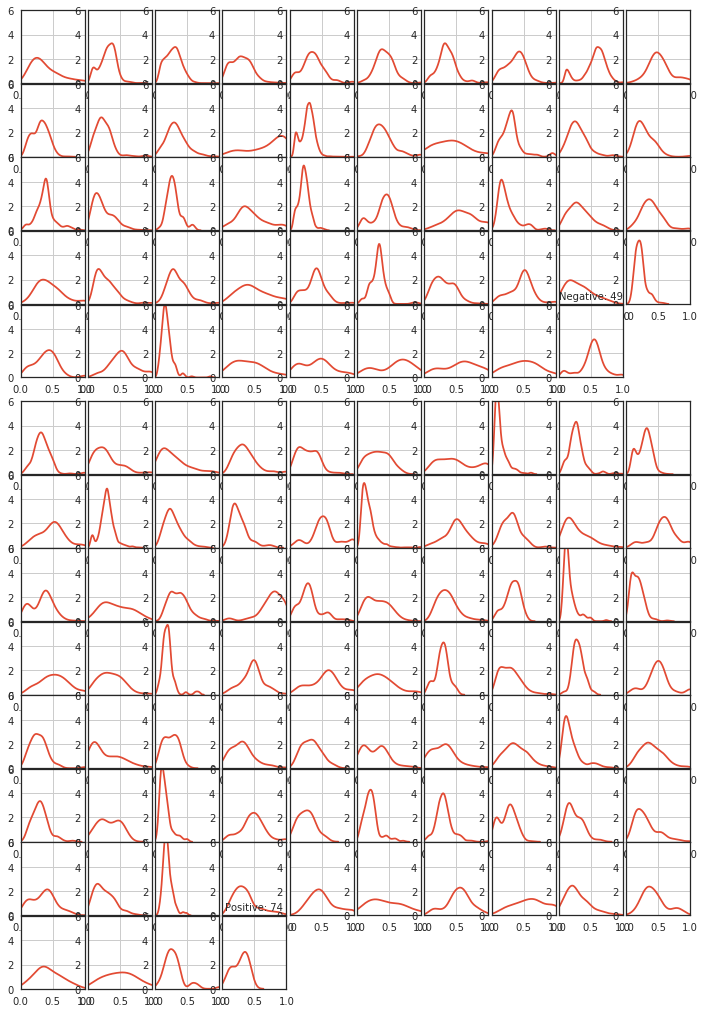

In [163]:
with plt.style.context("seaborn-whitegrid"):
    plt.rcParams["axes.edgecolor"] = "0.15"
    plt.rcParams["axes.linewidth"]  = 1.25

    fig = plt.figure(facecolor='w', figsize=(12,18))
    x1 = 'HIV_status'
    x2 = 'combo'
    x3 = 'Putative_histology'
    x4 = 'patient'
    y = 'adj_t_DNA_AF'
#     y = 't_DNA_AF'
    groups = dfm[x1].unique().tolist()

    gs = gridspec.GridSpec(2, 1, height_ratios=[5,8], width_ratios=[1], 
                           wspace=0.05, # horizontal space
                           hspace=0.05  # vertical space
                          )
    for n, gr in enumerate(groups):
        dfm1  = dfm[dfm[x1] == gr]
        pats = dfm1[x4].unique().tolist()
        gs01 = gridspec.GridSpecFromSubplotSpec(int(len(pats)/10+1), 10,  subplot_spec=gs[n], wspace=0.05, hspace=0.01)
        
        for k, pat in enumerate(pats):
            ax = fig.add_subplot(gs01[k], facecolor='white')           
            sns.distplot(dfm[dfm[x4] == pat][y].astype(float), hist=False)
            ax.set_xlim(0,1)
            ax.set_ylim(0,6)
            ax.set_xlabel('')
        ax.set_title('{0}: {1}'.format(gr, len(pats)), fontsize=10)

   
of = '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/124_patients/AF_distribution_by_patient.png'
# %time plt.savefig(of, bbox_inches='tight',dpi=300)

plt.show()
plt.close()

/home/szong/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


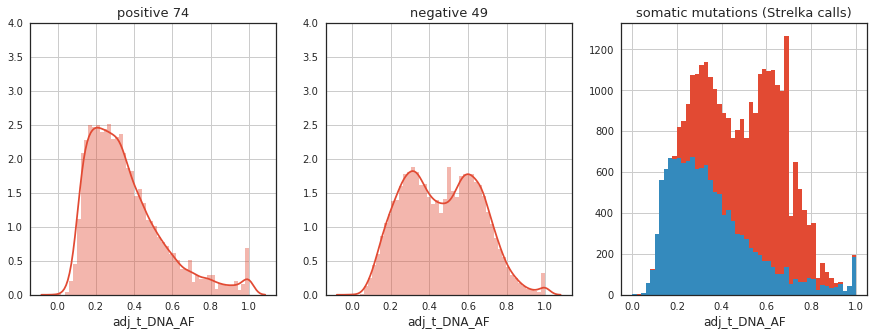

In [46]:
with plt.style.context("seaborn-whitegrid"):
    plt.rcParams["axes.edgecolor"] = "0.15"
    plt.rcParams["axes.linewidth"]  = 1.25

    fig = plt.figure(facecolor='w', figsize=(15,5))
    x1 = 'HIV_status'
    x2 = 'combo'
    x3 = 'Putative_histology'
    y = 'adj_t_DNA_AF'
#     y = 't_DNA_AF'
    ax1 = plt.subplot(131,facecolor='w')
    # sns distribution plot
    dfm1 = dfm[dfm.HIV_status == 'Positive']
    patients = dfm1.patient.unique().tolist()
    sns.distplot(dfm1[y].astype(float))
    ax1.set_ylim(0,4)
    plt.title('positive {}'.format(len(patients)),  fontsize=13)


    ax2 = plt.subplot(132,facecolor='w')
    dfm2 = dfm[dfm.HIV_status == 'Negative']
    patients = dfm2.patient.unique().tolist()
    sns.distplot(dfm2[y].astype(float))
    ax2.set_ylim(0,4)
    plt.title('negative {}'.format(len(patients)), fontsize=13)


    # dfm2  = dfm[dfm.reanne_HIV_status == 'Negative']
    # patients = dfm2.patient.unique().tolist()
    # for patient in patients[:10]:
    #     sns.distplot(dfm[dfm.patient == patient][y].astype(float), hist=False)


    # density plot
    ax3 = plt.subplot(133,facecolor='w')
    ax3.hist(dfm[dfm.HIV_status == 'Negative'][y].astype(float), bins=50)
    ax3.hist(dfm[dfm.HIV_status == 'Positive'][y].astype(float), bins=50)

    ax3.set_title("somatic mutations (Strelka calls)",  fontsize=13)
    ax3.set(xlabel='adj_t_DNA_AF')
#     ax3.set(xlabel='t_DNA_AF')

of = '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/124_patients/AF_distribution.png'
# %time plt.savefig(of, bbox_inches='tight',dpi=300)
plt.show()
plt.close()

kernel density estimate + histogram, area under the curve = 1


should use tumour content adjusted AF
individual patient

CPU times: user 3.07 s, sys: 68 ms, total: 3.14 s
Wall time: 2.2 s


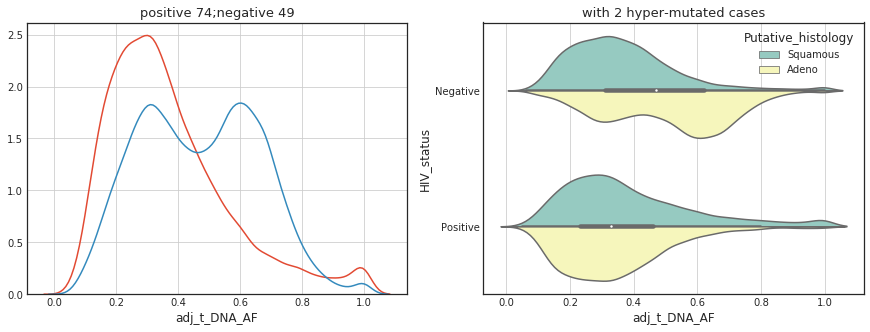

In [23]:

with plt.style.context("seaborn-whitegrid"):
    plt.rcParams["axes.edgecolor"] = "0.15"
    plt.rcParams["axes.linewidth"]  = 1.25

    fig = plt.figure(facecolor='w', figsize=(15,5))
    x1 = 'HIV_status'
    x2 = 'combo'
    x3 = 'Putative_histology'
    y = 'adj_t_DNA_AF'

    ax1 = plt.subplot(121,facecolor='w')
    # sns distribution plot
    dfm1 = dfm[dfm.HIV_status == 'Positive']
    patp = dfm1.patient.unique().tolist()
    sns.distplot(dfm1[y].astype(float), hist=False)

    dfm2 = dfm[dfm.HIV_status == 'Negative']
    patients = dfm2.patient.unique().tolist()
    sns.distplot(dfm2[y].astype(float), hist=False)

    plt.title('positive {0};negative {1}'.format(len(patp),len(patients)), fontsize=13)
    ax2 = plt.subplot(122, facecolor='w')
    sns.violinplot(x=y, y=x1, data=dfm, hue=x3, split=True, palette="Set3")# palette={"Positive": "r", "Negative": "b", "Adeno":"r", "Squamous":"b"})
    plt.title('with 2 hyper-mutated cases', fontsize=13)
    
#    
of = '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/124_patients/AF_distribution_with_2_hyper-mutated_cases.png'
%time plt.savefig(of, bbox_inches='tight',dpi=300)
plt.show()
plt.close()

In [17]:
dfr = dfm[~dfm.patient.isin(['HTMCP-03-06-02007', 'HTMCP-03-06-02026'])]

CPU times: user 3.23 s, sys: 49 ms, total: 3.28 s
Wall time: 3.73 s


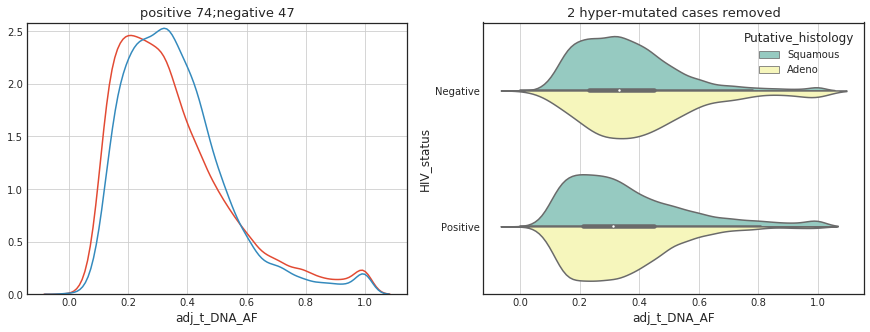

In [31]:
# remove hyper-mutated cases

with plt.style.context("seaborn-whitegrid"):
    plt.rcParams["axes.edgecolor"] = "0.15"
    plt.rcParams["axes.linewidth"]  = 1.25

    fig = plt.figure(facecolor='w', figsize=(15,5))
    x1 = 'HIV_status'
    x2 = 'combo'
    x3 = 'Putative_histology'
    y = 'adj_t_DNA_AF'

    ax1 = plt.subplot(121,facecolor='w')
    # sns distribution plot
    dfr1 = dfr[dfr.HIV_status == 'Positive']
    patp = dfr1.patient.unique().tolist()
    sns.distplot(dfr1[y].astype(float), hist=False)

    dfr2 = dfr[dfr.HIV_status == 'Negative']
    patients = dfr2.patient.unique().tolist()
    sns.distplot(dfr2[y].astype(float), hist=False)

    plt.title('positive {0};negative {1}'.format(len(patp),len(patients)), fontsize=13)
    ax2 = plt.subplot(122, facecolor='w')
    sns.violinplot(x=y, y=x1, data=dfr, hue=x3, split=True, palette="Set3")#palette={"Adeno": "blue", "Squamous":"green"})
    plt.title('2 hyper-mutated cases removed', fontsize=13)

#    
of = '/projects/trans_scratch/validations/workspace/szong/Cervical/variant_bwamem/124_patients/AF_distribution_2_hyper-mutated_cases_removed.png'
%time plt.savefig(of, bbox_inches='tight',dpi=300)
plt.show()
plt.close()

In [52]:
dfm2.head(2)

,gene,chromosome,position,ref_base,alt_base,in_strelka,adj_t_DNA_AF,snv_id,patient,HIV_status,Putative_histology
0,SAMD11,1,865615,C,A,not_in_strelka,0.81,SAMD11_1_865615_C_A,HTMCP-03-06-02007,Negative,Adeno
1,AGRN,1,980867,C,T,not_in_strelka,1.00,AGRN_1_980867_C_T,HTMCP-03-06-02007,Negative,Adeno
